In [1]:
# Only needed when FGEM is NOT installed by user
import sys
sys.path.insert(1, '../')

from fgem.world import World
from fgem.utils.config import get_config_from_json
from fgem.subsurface import *
from tqdm import tqdm
from fgem.utils.utils import *
from fgem.utils.constants import *

from scipy.spatial import cKDTree
import matplotlib.colors as colors
from shapely.geometry import Point

### Variable Thermal Conductivity

In [ ]:
data_filepath = "../../clgwg/SBT/nov_vallourec_validation/Tinj_150gpm_9_19.xlsx"
data = pd.read_excel(data_filepath)
data = data[data['Time [hrs]']<=12].reset_index(drop=True)
Tintimearray = data['Time [seconds]'].values
Tintemperaturearray = data['Tin [C]'].values
skip = 8

T_inj = 22 # C
T_amb = 21 # C

title = "150 GPM Flow Rate (19-20 Sept 2022)"
fig = plt.figure()

# ks = [1.5, 2, 2.5, 3, 3.5, 4]
# ks = [1, 2, 3]
ks = [2.3]
linestyles = ['-', '--', '-.', ':']


for idx, k in tqdm(enumerate(ks)):
    config = get_config_from_json('configs/example_validate_coaxial.json')
    config['krock'] = k
    project = World(config)
    
    times = []
    timecurr = 0
    
    for i in range(1, 100000):
        T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
        
        timestep = project.timesteps[i]
        project.step_update_record(T_inj=T_inj, T_amb=T_amb)
    
        timecurr += timestep.total_seconds()
        times.append(timecurr)
    
        if timecurr/3600 >= 12:
            break

    project.compute_economics()
    times = np.array(times)/3600
    df_records = project.df_records

    if idx == 0:
        plt.scatter(data['Time [hrs]'][::skip], data['Tin [C]'][::skip], facecolors='none', edgecolor='blue', label="Inlet Temperature (NOV)")
        plt.plot(times, df_records['Inj Temp [deg C]'].values, linewidth=2, color='blue', label='Inlet Temperature (SBT)')
        plt.scatter(data['Time [hrs]'][::skip], data['Tout [C]'][::skip], facecolors='none', edgecolor='red', label="Outlet Temperature (NOV)")
        
    plt.plot(times, df_records['WH Temp [deg C]'].values, linewidth=2, color='red', linestyle=linestyles[idx], label='Outlet Temperature (SBT) [$k_{rock}$' + f'={k} W/m-C]')

plt.axis([0, times[-1], T_inj-10, df_records['WH Temp [deg C]'].mean()+1.5*(df_records['WH Temp [deg C]'].mean()-T_inj)])

plt.xlabel('Time [hours]', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.gca().set_facecolor((1, 1, 1))
plt.grid(True)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(title)
fig.tight_layout()

# fig.savefig('fig_production_temperature_linear.png')

### STM Model

In [ ]:
df_grid = pd.read_pickle("../../common/data/stm/stm_conus.pkl")
# combine all files in one place and save    
df_maps = {}
for depth in df_grid.Depth.unique():
    df = df_grid[df_grid.Depth == depth].sort_values(["Easting", "Northing"]).reset_index(drop=True).copy()
    df_maps[depth] = df[["BHT_pred", "BHT_pred_std", "thermal_conductivity_pred", "thermal_conductivity_pred_std", "T_0", "Easting", "Northing"]].copy()
    # df_maps[depth] = df[["BHT_pred", "BHT_pred_std", "T_0", "Easting", "Northing", "geometry"]].copy()

In [ ]:
k = 10
target_quantity = "BHT"#"thermal_conductivity"

def harrison(z):
    return -2.3449e-6 * z**2 + 0.018268 * z - 16.512
def forster(z):
    return 0.017*z - 6.58

def compute_temperature(df_model, location, depth, k=2):
    A = (np.abs(df_model["Easting"] - location.coords.xy[0][0]) + \
           np.abs(df_model["Northing"] - location.coords.xy[1][0]))
    indices = np.argpartition(A, k)[:k].tolist()
    inv_distances = (A[indices].sum()/A[indices]).values
    inv_distances /= inv_distances.sum()
    raw_vals = df_model.loc[indices, [target_quantity+"_pred", target_quantity+"_pred_std"]]
    T, T_std = (inv_distances * raw_vals[target_quantity+"_pred"].values).sum(), (inv_distances * raw_vals[target_quantity+"_pred_std"].values).sum()
    # row_means = df_model.loc[indices, ["BHT_pred", "BHT_pred_std"]].mean()
    # T, T_std = row_means["BHT_pred"], row_means["BHT_pred_std"]
    return T, T_std

df_logs = []

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

log_filename = "NOV_center_wells_30.368864,-95.963581.csv" 
log_filepath = os.path.join("../../common/data/well_logs/", log_filename)
plot_correction, calibrate = False, False

lat, lon = log_filename.split('.csv')[0].split('_')[-1].split(',')
lat, lon = float(lat.strip()), float(lon.strip())
northing_easting = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=LATLON_CRS).to_crs(UNIFIED_CRS).loc[0, "geometry"]
easting, northing = northing_easting.xy[0][0], northing_easting.xy[1][0]
location = Point(easting, northing)

target_depths = [d for d in df_grid.Depth.unique() if d<=10000]
Ts, T_stds = [], []
for depth in target_depths:
    T, T_std = compute_temperature(df_maps[depth], location, depth, k)
    Ts.append(T)
    T_stds.append(T_std)
Ts = np.array(Ts)
T_stds = np.array(T_stds)

df_log = pd.read_csv(log_filepath)
df_log = df_log[~((df_log["T"]<0) | (df_log["Depth"]<0))]
df_log["correction"] = np.maximum(harrison(df_log["Depth"]*1000), -5)
df_log["T_corrected"] = df_log["T"] + df_log["correction"]# * (df_log.Depth*1000 > 610) # 610 is where the Harrison fit starts http://ogs.ou.edu/docs/specialpublications/SP83-1.pdf


df_log.drop_duplicates(subset=["Depth"], inplace=True)
df_log.sort_values("Depth", inplace=True)
df_log.reset_index(inplace=True, drop=True)

df_log["gg"] = (df_log["T"].diff()/df_log["Depth"].diff()).fillna(-1)
df_logs.append(df_log)


ax.scatter(df_log["T_corrected"] if plot_correction else df_log["T"].values, 
                 df_log["Depth"].values, color='black', label="NOV Well Data", s=10)
# ax.plot([20+30 * d/1000 for d in target_depths], [d/1000 for d in target_depths], 'gray', label="NOV Well Geotherm")

ax.plot(Ts, [d/1000 for d in target_depths], 'tab:red', label="Stanford Model")
ax.fill_betweenx([d/1000 for d in target_depths], Ts-T_stds, Ts+T_stds, color="tab:red", alpha=0.1)
ax.invert_yaxis()

# ax.set_xlim([1,4])
# ax.set_xlabel("Rock Thermal Conductivity [W/m-K]")
ax.set_xlabel("Temperature [$^\circ C$]")
ax.set_ylabel("Depth [km]")

plt.legend()
plt.show()


### Modeled Thermal Conductivity

#### 150 GPM test

In [ ]:
data_filepath = "../../clgwg/SBT/nov_vallourec_validation/Tinj_150gpm_9_19.xlsx"
data = pd.read_excel(data_filepath)
data = data[data['Time [hrs]']<=12].reset_index(drop=True)
Tintimearray = data['Time [seconds]'].values
Tintemperaturearray = data['Tin [C]'].values
skip = 8

config = get_config_from_json('configs/example_validate_coaxial.json')
config['dx'] = 25
project = World(config)

T_inj = 22 # C
T_amb = 21 # C

times = []
timecurr = 0

for i in range(1, 100000):
    T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
    
    timestep = project.timesteps[i]
    project.step_update_record(T_inj=T_inj, T_amb=T_amb)

    timecurr += timestep.total_seconds()
    times.append(timecurr)

    if timecurr/3600 >= 12:
        break

project.compute_economics()
times = np.array(times)/3600
df_records = project.df_records

title = "150 GPM Flow Rate (19-20 Sept 2022)"
fig = plt.figure()

plt.scatter(data['Time [hrs]'][::skip], data['Tin [C]'][::skip], facecolors='none', edgecolor='blue', label="Inlet Temperature (NOV)")
plt.plot(times, df_records['Inj Temp [deg C]'].values, linewidth=2, color='blue', label='Inlet Temperature (SBT)')

plt.scatter(data['Time [hrs]'][::skip], data['Tout [C]'][::skip], facecolors='none', edgecolor='red', label="Outlet Temperature (NOV)")
plt.plot(times, df_records['WH Temp [deg C]'].values, linewidth=2, color='red', label='Outlet Temperature (SBT)')

plt.axis([0, times[-1], T_inj-10, df_records['WH Temp [deg C]'].mean()+1.5*(df_records['WH Temp [deg C]'].mean()-T_inj)])

plt.xlabel('Time [hours]', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.gca().set_facecolor((1, 1, 1))
plt.grid(True)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(title)
fig.tight_layout()

# fig.savefig('fig_production_temperature_linear.png')

#### 75 GPM Test

In [ ]:
data_filepath = "../../clgwg/SBT/nov_vallourec_validation/Tinj_75gpm_9_26.xlsx"
data = pd.read_excel(data_filepath)
data = data[data['Time [hrs]']<=24].reset_index(drop=True)
Tintimearray = data['Time [seconds]'].values
Tintemperaturearray = data['Tin [C]'].values
skip = 8

config = get_config_from_json('configs/example_validate_coaxial.json')
config['dx'] = 25
config["m_prd"] = config["m_prd"]/2
project = World(config)

T_inj = 22 # C
T_amb = 21 # C

times = []
timecurr = 0

for i in range(1, 100000):
    T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
    
    timestep = project.timesteps[i]
    project.step_update_record(T_inj=T_inj, T_amb=T_amb)

    timecurr += timestep.total_seconds()
    times.append(timecurr)

    if timecurr/3600 >= 24:
        break

project.compute_economics()
times = np.array(times)/3600
df_records = project.df_records

title = "75 GPM Flow Rate (26 Sept 2022)"
fig = plt.figure()

plt.scatter(data['Time [hrs]'][::skip], data['Tin [C]'][::skip], facecolors='none', edgecolor='blue', label="Inlet Temperature (NOV)")
plt.plot(times, df_records['Inj Temp [deg C]'].values, linewidth=2, color='blue', label='Inlet Temperature (SBT)')

plt.scatter(data['Time [hrs]'][::skip], data['Tout [C]'][::skip], facecolors='none', edgecolor='red', label="Outlet Temperature (NOV)")
plt.plot(times, df_records['WH Temp [deg C]'].values, linewidth=2, color='red', label='Outlet Temperature (SBT)')

plt.axis([0, times[-1], T_inj-10, df_records['WH Temp [deg C]'].mean()+1.5*(df_records['WH Temp [deg C]'].mean()-T_inj)])

plt.xlabel('Time [hours]', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.gca().set_facecolor((1, 1, 1))
plt.grid(True)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(title)
fig.tight_layout()

# fig.savefig('fig_production_temperature_linear.png')

### TEA

In [2]:
# data_filepath = "../../clgwg/SBT/nov_vallourec_validation/Tinj_75gpm_9_26.xlsx"
# data = pd.read_excel(data_filepath)
# data = data[data['Time [hrs]']<=24].reset_index(drop=True)
# Tintimearray = data['Time [seconds]'].values
# Tintemperaturearray = data['Tin [C]'].values

In [45]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1W'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 10 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 60
config['krock'] = 2.3

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = 160#(config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2
config['k_tube'] = 0.088

# experimental params
# config['powerplant_k'] = 1
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 10
config['powerplant_capacity'] = 2

project = World(config)

T_inj = 22 # C
T_amb = 21 # C

for i in tqdm(range(1, project.max_simulation_steps-1)):
    timecurr = (project.time_curr - project.time_init).total_seconds()
    # T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
    # project.step_update_record(T_inj=T_inj, T_amb=T_amb)
    # project.step_update_record(T_amb=T_amb)
    # project.step_update_record(T_inj=T_inj)
    project.step_update_record()
    # print(project.powerplant.m_prd_norm, project.power_output_MWh_kg)
    
project.compute_economics()
df_records = project.df_records


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:02<00:00, 556.65it/s]

LCOE: 643 $/MWh
NPV: -129 $MM
PBP: 0 yrs


In [46]:
print(config['Tres_pp_design'])
print(project.powerplant_capacity) # MWe
print(1.834 * 1e6/(project.powerplant_capacity*1e3)) # USD/kWe-yr
print(project.powerplant_capex*1e6/(project.powerplant_capacity*1e3)) #USD/kWe
print(project.df_records['Net Power Generation [MWhe]'].sum()/project.L/1e3) #GWhe/annually
print(project.reservoir.Tres_init)
print(project.opex_total.mean()*1000)
print(project.capex_total[0])

160
2
917.0
2506.393005128569
16.22057
440.0
88.20194170824342
142.52714231630338


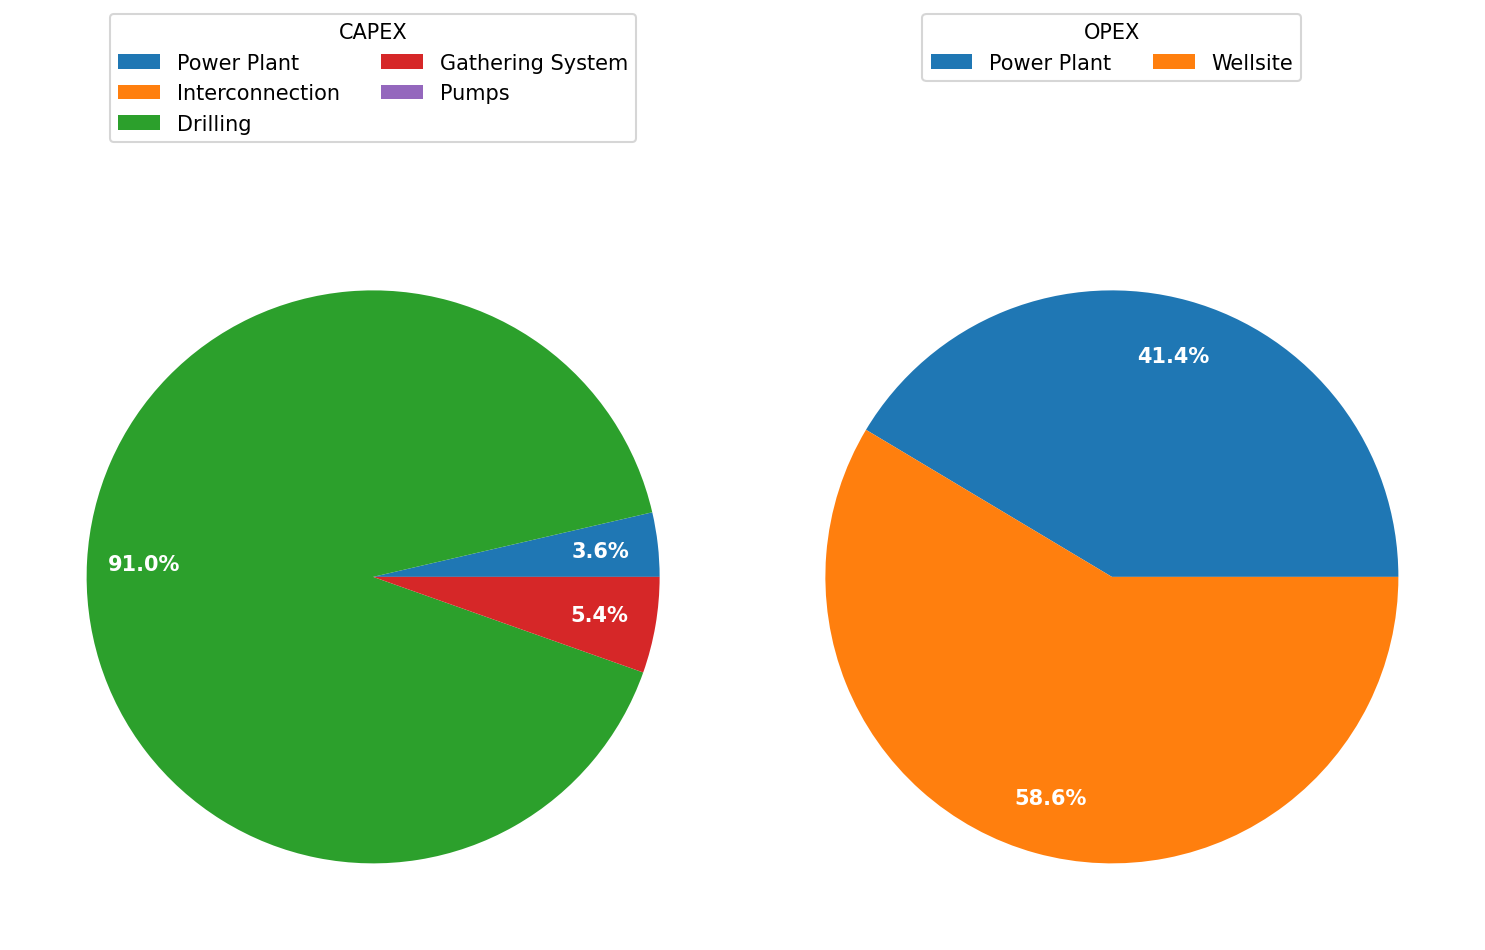

In [47]:
fig = project.plot_economics()

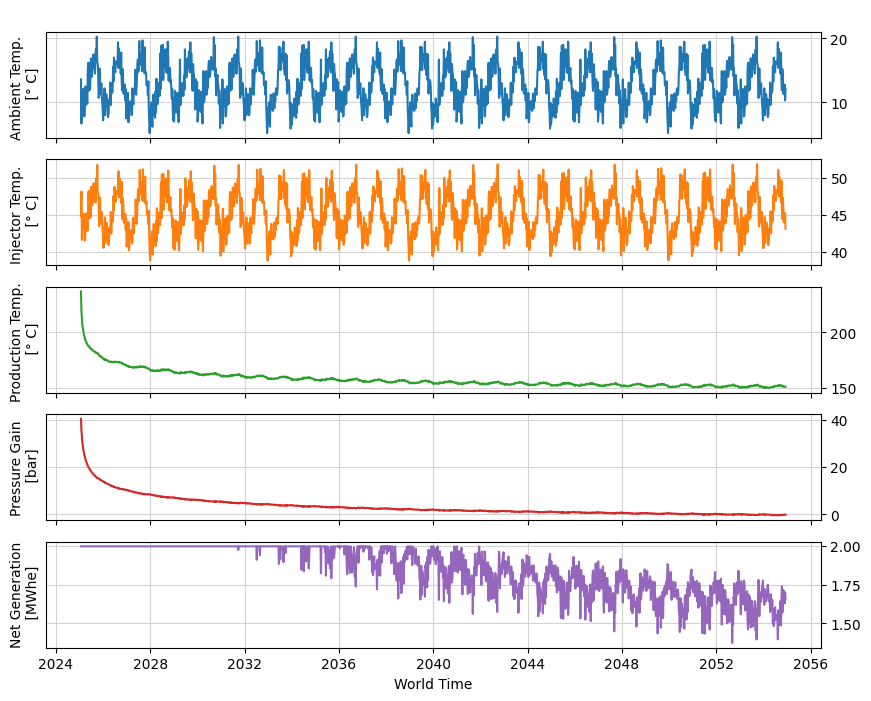

In [49]:
fig = project.plot_operations(span = range(2, project.step_idx),
                              figsize=(10, 8),
                                          qdict = {
            # "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [° C]",
          # 'M_Market [kg/s]': "Field Production \n [kg/s]",
          'Inj Temp [deg C]': "Injector Temp. \n [° C]",
          "WH Temp [deg C]": "Production Temp. \n [° C]",
          "Producer Wellhead Pressure [bar]": "Pressure Gain\n [bar]",
          # "Pumping Power [MWe]": "Pumping Req. \n [MWe]",
          # "Specific Power Output [kWh/kg]": "Specific Power\n [kWh/kg]",
          "Net Power Output [MWe]": "Net Generation\n [MWhe]",
        })

### Sensitivity Analysis

#### System Design and Ops

In [ ]:
# config = get_config_from_json('configs/example_validate_coaxial.json')
# config['resample'] = '1M'
# config['oversample_first_day'] = None
# config['dx'] = 125

# # fixed throughout the analysis
# config['L'] = 30
# config['num_prd'] = 10 # num wells
# config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
# config['well_tvd'] = 7000
# config['surface_temp'] = 20
# config['itc'] = 0.0

# # subsurface knobs
# config['geothermal_gradient'] = 60
# # config['krock'] = 4

# # economics knobs
# config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# # config['d'] = 0.07

# # system design/ops knobs
# config['m_prd'] = 5
# config['Tres_pp_design'] = (config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2
# config['k_tube'] = 0.088

# # experimental params
# config['powerplant_k'] = 10
# # config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 10

# outputs = []
# dfs = {}
# cols = ["VIT Thermal Conductivity [W/m-C]", "Well Flow Rate [l/s]", "LCOE [USD/MWh]", "NPV [MUSD]", "PPA NPV [MUSD]",
#         "Power Plant Design Temp. [° C]", "Installed Nameplate Capacity [MWe]", "Annual Net Generation [GWhe]", "Avg Production Temp. [° C]", 
#         "Plant Temperature Design Ratio",
#        ]

# ys = np.array([2, 3, 4, 5, 6])
# xs = np.array([220, 260, 300, 340, 380])

# for m_prd in tqdm(ys):
#     for T_design in xs:
#         config['m_prd'] = m_prd
#         config['Tres_pp_design'] = T_design
        
#         project = World(config)
#         for i in range(1, project.max_simulation_steps-1):
#             timecurr = (project.time_curr - project.time_init).total_seconds()
#             project.step_update_record()

#         project.compute_economics(print_outputs=False)
        
#         outputs.append([config['k_tube'], config['m_prd'], project.LCOE, project.NPV, project.PPA_NPV, 
#                          project.Tres_pp_design, project.powerplant_capacity, 
#                          project.df_records['Net Power Generation [MWhe]'].sum()/project.L/1e3, project.df_records['WH Temp [deg C]'].mean(),
#                        project.df_records['WH Temp [deg C]'].mean()/project.Tres_pp_design])
        

In [ ]:
# df_temp = pd.DataFrame(outputs, columns=cols)
# # df_temp["Temp Design Coeff"] = (df_teqmp['Plant Temperature Design Ratio']-1).abs()
# df_temp["Temp Design Coeff"] = df_temp['Plant Temperature Design Ratio']
# for m in df_temp['Well Flow Rate [l/s]'].unique():
#     mask = df_temp['Well Flow Rate [l/s]'] == m
#     plt.plot(df_temp["Temp Design Coeff"][mask], df_temp['LCOE [USD/MWh]'][mask], marker='o', label='$\dot{m}$' + f' = {m} l/s')

# plt.xlabel("Temp Design Coeff")
# plt.ylabel("LCOE [USD/MWhe]")
# plt.legend(loc='upper right');

In [ ]:
# xcol = "Well Flow Rate [l/s]"
# ycol = "Power Plant Design Temp. [° C]"
# ccol = "LCOE [USD/MWh]"

# df_temp = df_temp[df_temp["Power Plant Design Temp. [° C]"]>=145].reset_index(drop=True)
# pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
# pivot = pivot.astype(int)
# pivot.index = pivot.index.astype(int)
# pivot.columns = pivot.columns.round(2)

# fig, ax = plt.subplots(1, 1, dpi=150)
# sns.heatmap(pivot,annot=True, cmap="Spectral",
#                  cbar_kws={'label': ccol}, fmt=".0f", ax=ax, norm=colors.LogNorm())

# ax.set_xlabel(xcol);
# ax.set_ylabel(ycol);
# # ax.set_title(labels[strategy])

# # fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

In [54]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1M'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 10 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 60
# config['krock'] = 4

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = (config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2.75
config['k_tube'] = 0.088

# experimental params
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 10

outputs = []
dfs = {}
cols = ["VIT Thermal Conductivity [W/m-C]", "Well Flow Rate [l/s]", "LCOE [USD/MWh]", "NPV [MUSD]", "PPA NPV [MUSD]",
        "Power Plant Design Temp. [° C]", "Installed Nameplate Capacity [MWe]", "Annual Net Generation [GWhe]", "Avg Production Temp. [° C]", "Plant Temperature Design Ratio"
       ]

ys = np.array([4, 5, 6, 7, 8])
xs = np.round(0.25/np.array([3**i for i in range(5)]), 3)

for m_prd in tqdm(ys):
    for k_tube in xs:
        config['m_prd'] = m_prd
        config['k_tube'] = k_tube

        best_lcoe = 1e9
        best_project = None
        for T_design in np.arange(150, 210, 10):
            config['Tres_pp_design'] = T_design
            project = World(config)
            for i in range(1, project.max_simulation_steps-1):
                timecurr = (project.time_curr - project.time_init).total_seconds()
                project.step_update_record()

            project.compute_economics(print_outputs=False)
            if project.LCOE < best_lcoe:
                best_lcoe = project.LCOE
                best_project = project
        
        outputs.append([config['k_tube'], config['m_prd'], best_project.LCOE, best_project.NPV, best_project.PPA_NPV, 
                                         best_project.Tres_pp_design, best_project.powerplant_capacity, 
                                         best_project.df_records['Net Power Generation [MWhe]'].sum()/best_project.L/1e3, best_project.df_records['WH Temp [deg C]'].mean(),
                                           best_project.df_records['WH Temp [deg C]'].mean()/best_project.Tres_pp_design])
        

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-

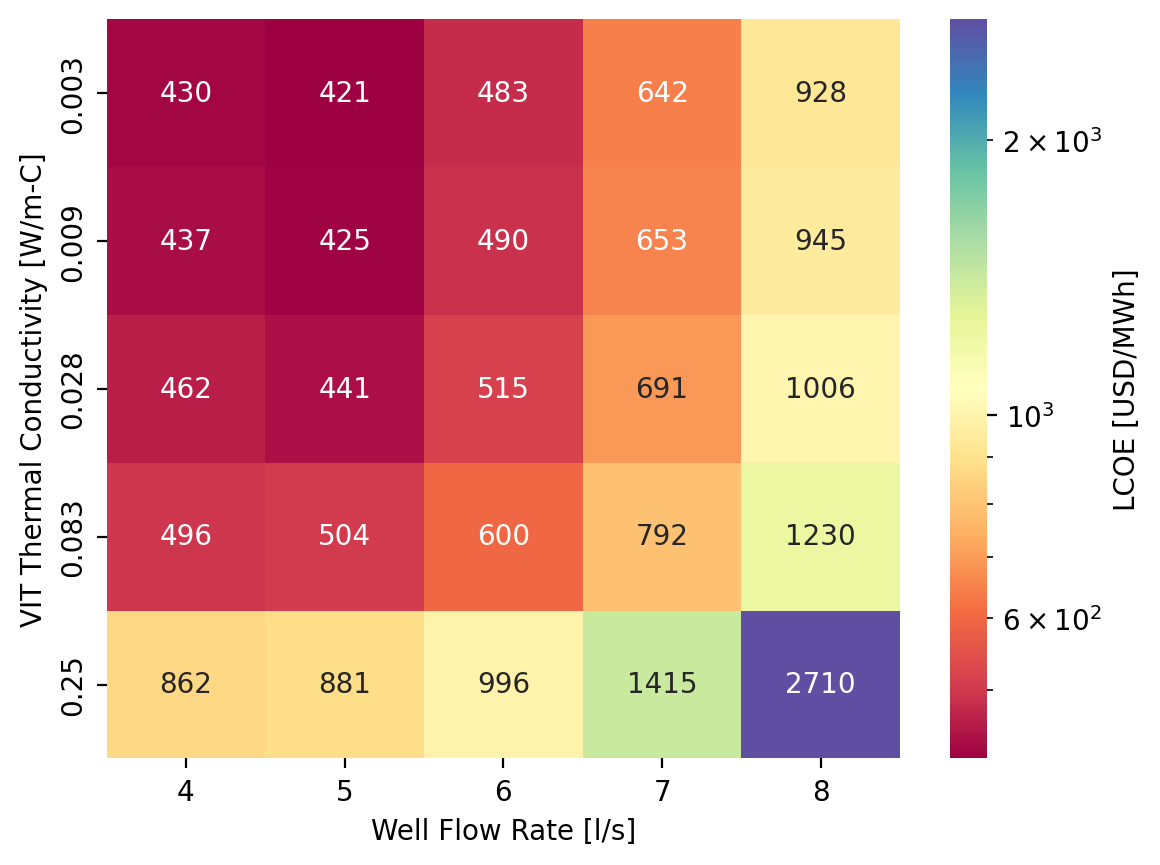

In [55]:
xcol = "Well Flow Rate [l/s]"
ycol = "VIT Thermal Conductivity [W/m-C]"
ccol = "LCOE [USD/MWh]"

df_temp = pd.DataFrame(outputs, columns=cols)
pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
pivot = pivot.astype(int)
pivot.index = pivot.index
pivot.columns = pivot.columns.round(2)

fig, ax = plt.subplots(1, 1, dpi=200)
sns.heatmap(pivot,annot=True, cmap="Spectral",
                 cbar_kws={'label': ccol}, fmt=".0f", ax=ax,  norm=colors.LogNorm())
ax.set_xlabel(xcol);
ax.set_ylabel(ycol);
# ax.set_title(labels[strategy])

# fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

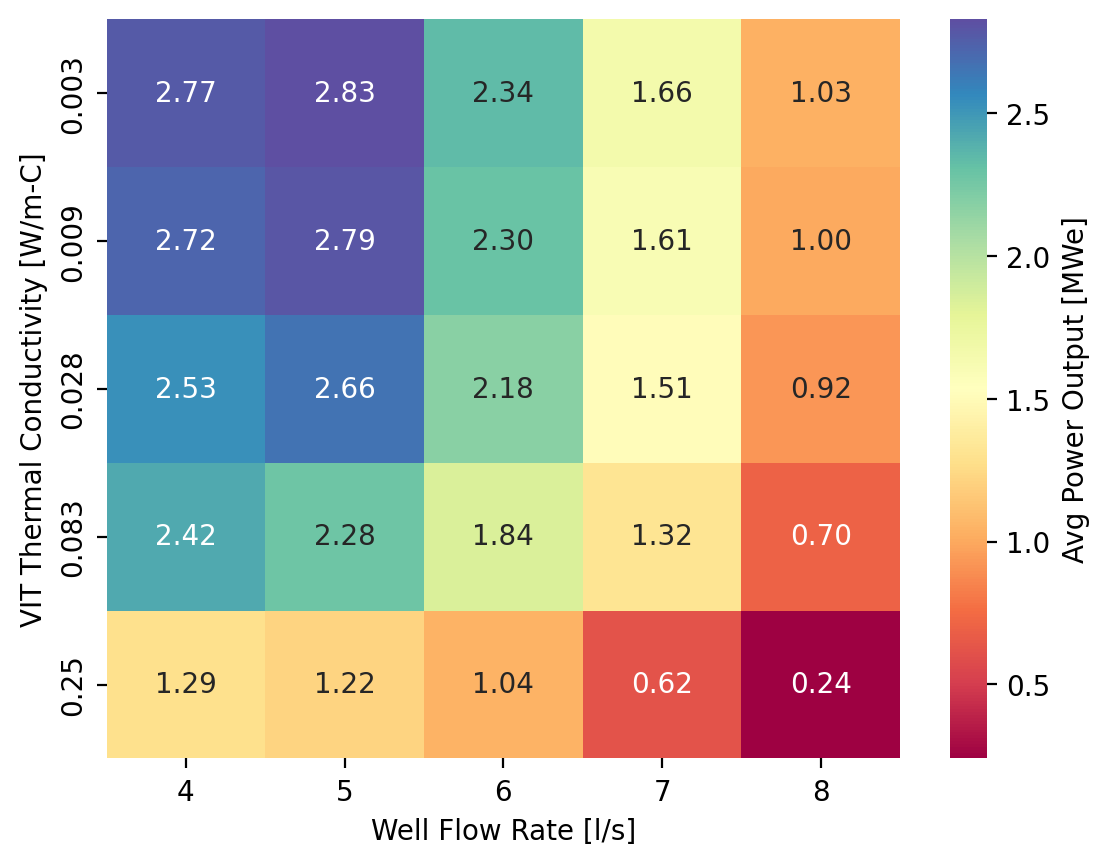

In [56]:
xcol = "Well Flow Rate [l/s]"
ycol = "VIT Thermal Conductivity [W/m-C]"
ccol = 'Avg Power Output [MWe]'

df_temp = pd.DataFrame(outputs, columns=cols)
df_temp['Avg Power Output [MWe]'] = df_temp["Annual Net Generation [GWhe]"]*1e3/8760


pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
pivot = pivot.round(2)
pivot.index = pivot.index
pivot.columns = pivot.columns.round(2)

fig, ax = plt.subplots(1, 1, dpi=200)
sns.heatmap(pivot,annot=True, cmap="Spectral",
                 cbar_kws={'label': ccol}, fmt=".2f", ax=ax)
ax.set_xlabel(xcol);
ax.set_ylabel(ycol);
# ax.set_title(labels[strategy])

# fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

#### Subsurface Conditions

In [57]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1M'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 10 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 60
# config['krock'] = 4

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = (config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2.75
config['k_tube'] = 0.088

# experimental params
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 10

outputs = []
dfs = {}
cols = ["VIT Thermal Conductivity [W/m-C]", "Well Flow Rate [l/s]", "LCOE [USD/MWh]", "NPV [MUSD]", "PPA NPV [MUSD]",
        "Power Plant Design Temp. [° C]", "Installed Nameplate Capacity [MWe]", "Annual Net Generation [GWhe]", "Avg Production Temp. [° C]",
        "Plant Temperature Design Ratio", "Rock Thermal Conductivity [W/m-C]"
       ]

ys = np.array([4, 5, 6, 7, 8])
xs = np.array([2, 2.5, 3, 3.5, 4])

for m_prd in tqdm(ys):
    for krock in xs:
        config['m_prd'] = m_prd
        config['krock'] = krock

        best_lcoe = 1e9
        best_project = None
        for T_design in np.arange(150, 210, 10):
            config['Tres_pp_design'] = T_design
            project = World(config)
            for i in range(1, project.max_simulation_steps-1):
                timecurr = (project.time_curr - project.time_init).total_seconds()
                project.step_update_record()

            project.compute_economics(print_outputs=False)
            if project.LCOE < best_lcoe:
                best_lcoe = project.LCOE
                best_project = project
        
        outputs.append([config['k_tube'], config['m_prd'], best_project.LCOE, best_project.NPV, best_project.PPA_NPV, 
                                         best_project.Tres_pp_design, best_project.powerplant_capacity, 
                                         best_project.df_records['Net Power Generation [MWhe]'].sum()/best_project.L/1e3, best_project.df_records['WH Temp [deg C]'].mean(),
                                           best_project.df_records['WH Temp [deg C]'].mean()/best_project.Tres_pp_design, config['krock']])
        

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-

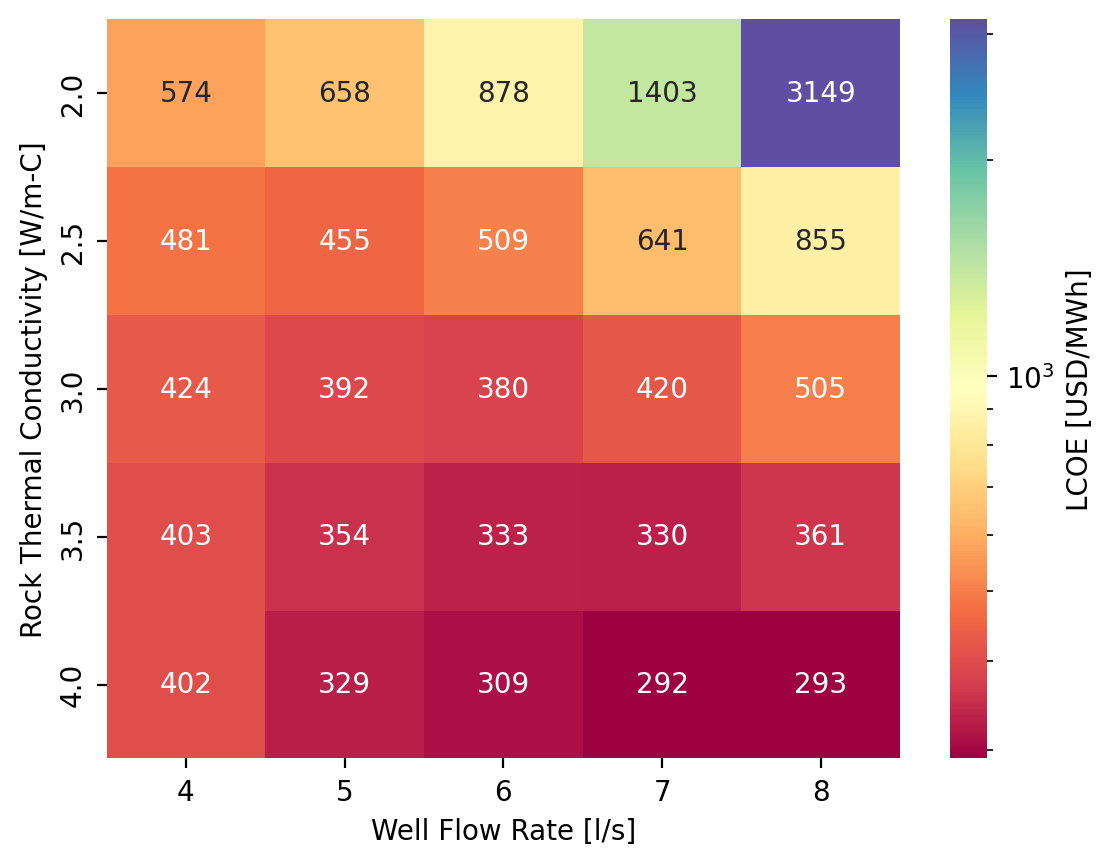

In [58]:
xcol = "Well Flow Rate [l/s]"
ycol = "Rock Thermal Conductivity [W/m-C]"
ccol = "LCOE [USD/MWh]"

df_temp = pd.DataFrame(outputs, columns=cols)
pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
pivot = pivot.astype(int)
pivot.index = pivot.index
pivot.columns = pivot.columns.round(2)

fig, ax = plt.subplots(1, 1, dpi=200)
sns.heatmap(pivot,annot=True, cmap="Spectral",
                 cbar_kws={'label': ccol}, fmt=".0f", ax=ax, norm=colors.LogNorm())
ax.set_xlabel(xcol);
ax.set_ylabel(ycol);
# ax.set_title(labels[strategy])

# fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

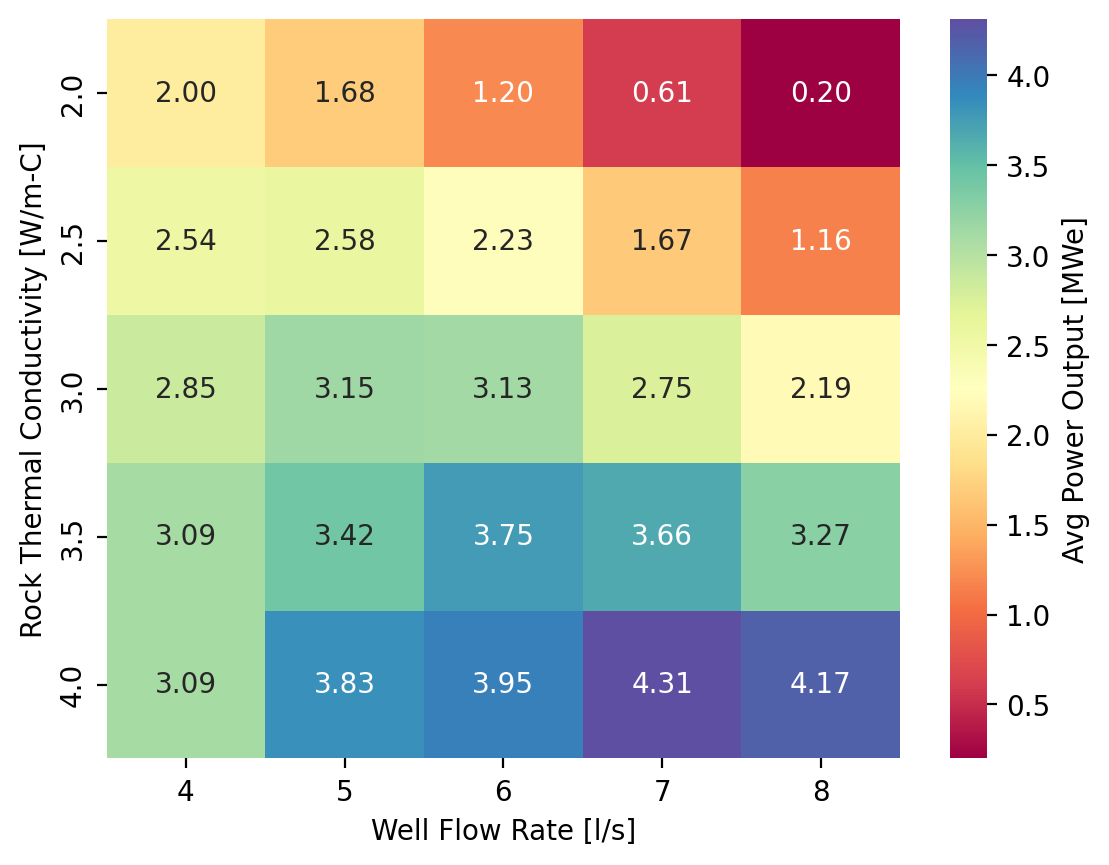

In [59]:
xcol = "Well Flow Rate [l/s]"
ycol = "Rock Thermal Conductivity [W/m-C]"
ccol = 'Avg Power Output [MWe]'

df_temp = pd.DataFrame(outputs, columns=cols)
df_temp['Avg Power Output [MWe]'] = df_temp["Annual Net Generation [GWhe]"]*1e3/8760


pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
pivot = pivot.round(2)
pivot.index = pivot.index
pivot.columns = pivot.columns.round(2)

fig, ax = plt.subplots(1, 1, dpi=200)
sns.heatmap(pivot,annot=True, cmap="Spectral",
                 cbar_kws={'label': ccol}, fmt=".2f", ax=ax)
ax.set_xlabel(xcol);
ax.set_ylabel(ycol);
# ax.set_title(labels[strategy])

# fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

#### Economic Params

In [60]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1M'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 10 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 60
# config['krock'] = 4

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = 185#(config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2.75
config['k_tube'] = 0.088

# experimental params
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 10

outputs = []
dfs = {}
cols = ["VIT Thermal Conductivity [W/m-C]", "Well Flow Rate [l/s]", "LCOE [USD/MWh]", "NPV [MUSD]", "PPA NPV [MUSD]",
        "Power Plant Design Temp. [° C]", "Installed Nameplate Capacity [MWe]", "Annual Net Generation [GWhe]", "Avg Production Temp. [° C]",
        "Plant Temperature Design Ratio", "Rock Thermal Conductivity [W/m-C]", 'Drilling Cost [USD/meter]', 'Discount Rate'
       ]

ys = np.array([100, 300, 500, 700, 900])
xs = np.array([0.04, 0.05, 0.06, 0.07, 0.08])

for drilling_cost in tqdm(ys):
    for d in xs:
        config['drilling_cost'] = drilling_cost
        config['d'] = d

        project = World(config)
        
        for i in range(1, project.max_simulation_steps-1):
            timecurr = (project.time_curr - project.time_init).total_seconds()
            project.step_update_record()

        project.compute_economics(print_outputs=False)
        best_project = project
        
        outputs.append([config['k_tube'], config['m_prd'], best_project.LCOE, best_project.NPV, best_project.PPA_NPV, 
                                         best_project.Tres_pp_design, best_project.powerplant_capacity, 
                                         best_project.df_records['Net Power Generation [MWhe]'].sum()/best_project.L/1e3, best_project.df_records['WH Temp [deg C]'].mean(),
                                           best_project.df_records['WH Temp [deg C]'].mean()/best_project.Tres_pp_design, config['krock'],
                                          config['drilling_cost'], config['d']])
        

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-

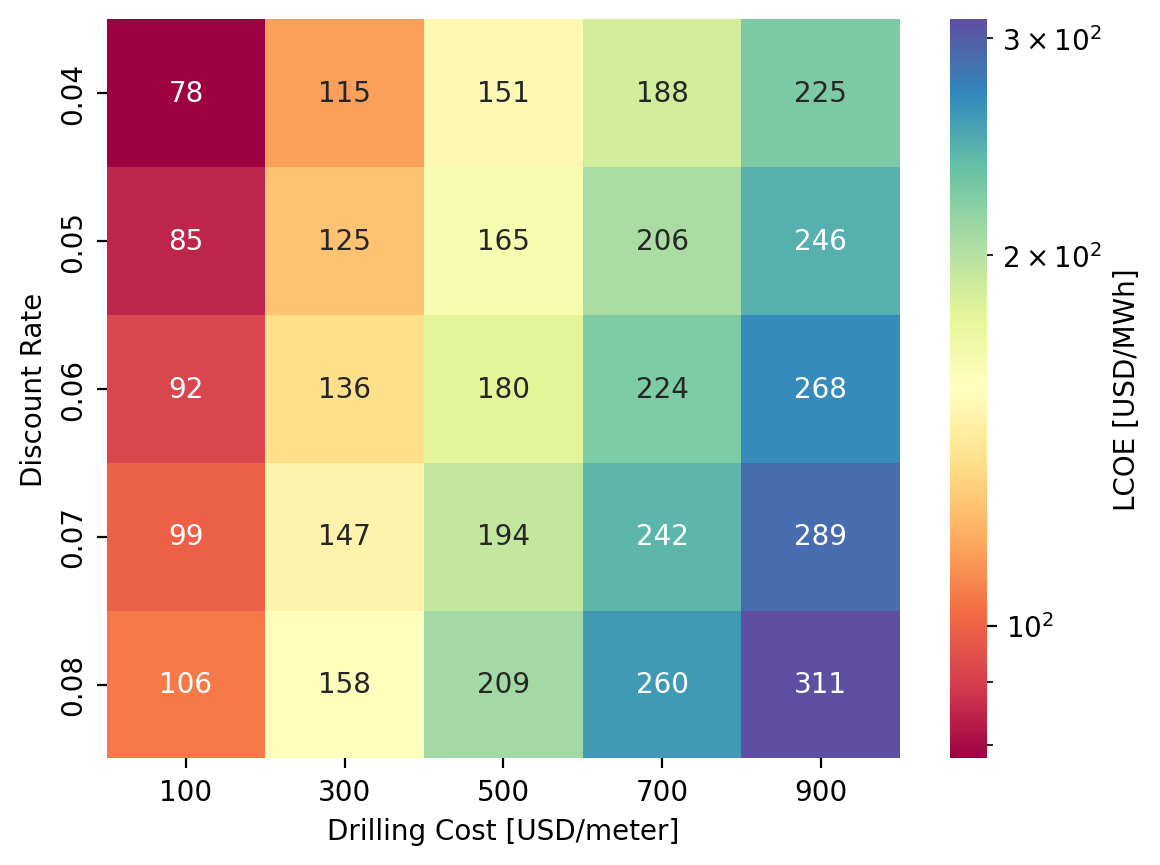

In [61]:
xcol = 'Drilling Cost [USD/meter]'
ycol = 'Discount Rate'
ccol = "LCOE [USD/MWh]"

df_temp = pd.DataFrame(outputs, columns=cols)
pivot = df_temp.pivot(index=ycol, columns=xcol, values=ccol)
pivot = pivot.astype(int)
pivot.index = pivot.index
pivot.columns = pivot.columns.round(2)

fig, ax = plt.subplots(1, 1, dpi=200)
sns.heatmap(pivot,annot=True, cmap="Spectral",
                 cbar_kws={'label': ccol}, fmt=".0f", ax=ax, norm=colors.LogNorm())
ax.set_xlabel(xcol);
ax.set_ylabel(ycol);
# ax.set_title(labels[strategy])

# fig.savefig(f"outputs/fig_{strategy}_sensitiviey.png")

### Other

In [ ]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1W'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 10 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 70
# config['krock'] = 4

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = (config['surface_temp'] + config['geothermal_gradient'] * config['well_tvd']/1000)/2.75
config['k_tube'] = 0.088

# config['powerplant_k'] = 1
# experimental params
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 100

project = World(config)

T_inj = 22 # C
T_amb = 21 # C

for i in tqdm(range(1, project.max_simulation_steps-1)):
    timecurr = (project.time_curr - project.time_init).total_seconds()
    # T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
    # project.step_update_record(T_inj=T_inj, T_amb=T_amb)
    # project.step_update_record(T_amb=T_amb)
    project.step_update_record()

project.compute_economics()
df_records = project.df_records


In [ ]:
fig = project.plot_operations(span = range(2, project.step_idx),
                              figsize=(10, 8),
                                          qdict = {
            # "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [° C]",
          # 'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "WH Temp [deg C]": "Production Temp. \n [° C]",
          "Producer Wellhead Pressure [bar]": "Pressure Gain\n [bar]",
          # 'Inj Temp [deg C]': "Injector Temp. \n [° C]",
          "Pumping Power [MWe]": "Pumping Req. \n [MWe]",
          "Net Power Output [MWe]": "Net Generation \n [MWhe]",
        })

In [ ]:
project.powerplant.power_output_MWh_kg*1e3

In [ ]:
project.Tres_pp_design

In [ ]:
project.powerplant.T_mix

In [ ]:
max_th_eff = 0.1
m = 20 #kg/s
thermal_energy = project.steamtable.hL_t(project.powerplant.T_mix)/3.6e6 #MWhth/kg
specific_output = thermal_energy*max_th_eff #MWhe/kg
power_output = specific_output * m * 3600
print(specific_output*1e3) #MWhe/kg
print(power_output)

In [ ]:
max_th_eff = 0.15
m = 93 #kg/s
thermal_energy = project.steamtable.hL_t(200)/3.6e6 #MWhth/kg
specific_output = thermal_energy*max_th_eff #MWhe/kg
power_output = specific_output * m * 3600
print(specific_output) #MWhe/kg
print(power_output)

In [ ]:
config = get_config_from_json('configs/example_validate_coaxial.json')
config['resample'] = '1W'
config['oversample_first_day'] = None
config['dx'] = 125

# fixed throughout the analysis
config['L'] = 30
config['num_prd'] = 100 # num wells
config['casing_inner_diam'] = 0.224409 #9-5/8", 40# with ID=8.835"
config['well_tvd'] = 7000
config['surface_temp'] = 20
config['itc'] = 0.0

# subsurface knobs
config['geothermal_gradient'] = 60
# config['krock'] = 4

# economics knobs
config['drilling_cost'] = 1800 #based on Dayo's work (Figure 5): https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2025/Akindipe.pdf
# config['d'] = 0.07

# system design/ops knobs
config['m_prd'] = 5
config['Tres_pp_design'] = 165
config['k_tube'] = 0.088

config['powerplant_k'] = 1
# experimental params
# config['powerplant_type'] = 'geophiresbinary'; config['powerplant_capacity'] = 100

project = World(config)

T_inj = 22 # C
T_amb = 21 # C

for i in tqdm(range(1, project.max_simulation_steps-1)):
    timecurr = (project.time_curr - project.time_init).total_seconds()
    # T_inj = np.interp(timecurr, Tintimearray, Tintemperaturearray)
    project.step_update_record(T_inj=T_inj, T_amb=T_amb)
    # project.step_update_record(T_amb=T_amb)
    # project.step_update_record()

project.compute_economics()
df_records = project.df_records


In [ ]:
project.m_prd.mean()

In [ ]:
project.powerplant.T_mix

In [ ]:
project.powerplant.power_output_MWh_kg*1e3